In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import shutil
from tqdm import tqdm

In [12]:
def advection_equation(function='Gaussian', boundary='periodic', method='Lax_Wendroff', nx=101, cf=0.5, a=1, L=10.0, t_final=20.0):
    dx = L/(nx-1) # Grid spacing
    dt = cf*dx/a  # Time step
    x = np.linspace(0, L, nx)
    # Initialize the solution array 
    if function=='Gaussian':
        x0=5
        u_initial = np.exp(-(x-x0)**2)
    elif function=='Step':
        u_initial = []
        for ex in x:
            if  (ex>=4) and (ex<=6):
                u_initial.append(1)
            else:
                u_initial.append(0)
        u_initial = np.array(u_initial)
    u_current = u_initial.copy()  # if i don't use copy, u_current would be a pointer to u_initial
    l2norm=[]
    l2norm.append(np.sqrt(np.sum(u_current**2)/len(u_current)))  # i expect it to be constant in time
    # another norm is the infinity norm: linfnorm = max(asb(u_nj)), for 1<=j<=J
    
    time=[]
    time.append(0.0)

    os.makedirs('./images')

    # Initilize time and iteration counter
    t = 0.0
    i = 0

    #save the initial conditions
    plt.plot(x, u_current)
    plt.title('Time='+str(round(t,2)))
    if function=='Gaussian':
        plt.ylim(0,1.1)
    plt.savefig('./images/fig_'+str(i).zfill(5)+'.png', dpi=200)
    plt.close()

    if method == 'Leapfrog':
        u_next = 0.5*(np.roll(u_current, 1)+np.roll(u_current, -1)) - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
        u_before = u_current.copy()
        u_current = u_next.copy()
        t += dt

    pbar = tqdm(desc = 'while loop', total = t_final)
    while t < t_final:
    # Note: np.roll(u_current, -1) is equivalent to u(j+1) and
    #       np.roll(u_current,  1) is equivalent to u(j-1)
    # using np.roll is equivalent to use periodic boundary conditions
        if method == 'Lax_Wendroff':
            u_next = u_current - (a*dt/(2*dx))*(np.roll(u_current, -1)-np.roll(u_current, 1)) + 0.5*((a*dt/dx)**2)*(np.roll(u_current, -1)-2*u_current + np.roll(u_current, 1))
        elif method == 'Lax_Friedrichs':
            u_next = 0.5*(np.roll(u_current, 1)+np.roll(u_current, -1)) - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
        elif method == 'FTCS':
            u_next = u_current - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
        elif method == 'Leapfrog':
            u_next = u_before - (a*dt/(dx))*(np.roll(u_current, -1) - np.roll(u_current, 1))

        if boundary == 'outflow':
            if method == 'Lax_Friedrichs':
                u_next[0] =  0.5*(u_current[1]+u_current[0]) - a*dt/(2*dx)*(u_current[1] - u_current[0])
                u_next[-1] =  0.5*(u_current[-2]+u_current[-1]) - a*dt/(2*dx)*(u_current[-1] - u_current[-2])
            elif method == 'Lax_Wendroff':
                u_next[0] = u_current[0] - (a*dt/(2*dx))*(u_current[1]-u_current[0]) + 0.5*((a*dt/dx)**2)*(u_current[1]-2*u_current[0] + u_current[0])
                u_next[-1] = u_current[-1] - (a*dt/(2*dx))*(u_current[-1]-u_current[-2]) + 0.5*((a*dt/dx)**2)*(u_current[-1]-2*u_current[-1] + u_current[-2])

        if method == 'Leapfrog':
            u_before = u_current.copy()
            u_current = u_next.copy()
        else:
            u_current = u_next.copy()
    
        #advance the time
        t += dt
        i += 1
    
        #compute the l2 norm and add the time to the time vector
        l2norm.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
        time.append(t)

        pbar.update(dt)
    
        #plot the current result and save in an image every 10 iterations
        if (i%10==0):
            plt.plot(x, u_current)
            plt.title('Time='+str(round(t,2)))
            if function=='Gaussian':
                plt.ylim(0, 1.1)
            plt.savefig('./images/fig_'+str(i).zfill(5)+'.png', dpi=200)
            plt.close()

    pbar.close()
    
    # Plot the final solution
    plt.plot(x, u_initial, label='Initial')
    plt.plot(x, u_current, label='Final')
    plt.title('Time='+str(round(t,2)))
    if function=='Gaussian':
        plt.ylim(0, 1.1)
    plt.legend()
    plt.savefig('./plot_finale_%s_%s_%s_cf_%0.2f_nx_%i.png' % (function, boundary, method, cf, nx), dpi=200)
    plt.show()
    plt.close()

    # set the directory where your images are stored
    directory = "./images/"
    
    # get the list of image files in the directory
    files = os.listdir(directory)
    
    # sort the files in alphanumeric order
    files=sorted(files)

    with imageio.get_writer('./movie_%s_%s_%s_cf_%0.2f_nx_%i.mp4' %(function, boundary, method, cf, nx), mode='I', quality=10) as writer:
        for file in files:
            image = imageio.imread('./images/'+file)
            writer.append_data(image)

    files=[]

    if function=='Gaussian':
        #Compare with data stored
        if method == 'Lax_Wendroff':
            l2_saved=np.genfromtxt('./l2norm_LAXWENDROFF.dat', comments='#')
        elif method == 'Lax_Friedrichs':
            l2_saved=np.genfromtxt('./l2norm_LAX.dat', comments='#')
        elif method == 'FTCS':
            l2_saved=np.genfromtxt('./l2norm_FTCS.dat', comments='#')
        elif method == 'Leapfrog':
            l2_saved=np.genfromtxt('./l2norm_LEAPFROG.dat', comments='#')
        plt.plot(time,l2norm/l2norm[0], color = 'lightblue', label = 'Numerical')
        plt.plot(l2_saved[:,0], l2_saved[:,1]/l2_saved[0,1], '+', color = 'green', label = 'Analytical')
        if boundary == 'outflow':
            plt.yscale("log")
        plt.title('$L^{2}-norm$')
        plt.xlabel('Time')
        if boundary == 'outflow':
            plt.ylabel('$Log(L^{2}-norm)$')
        elif boundary == 'periodic':
            plt.ylabel('$L^{2}-norm$')
        plt.legend()
        plt.savefig('./l2norm_%s_%s_%s_cf_%0.2f_nx_%i.png' % (function, boundary, method, cf, nx), dpi=200)
        plt.show()
        plt.close()

    elif function=='Step':
        plt.plot(time,l2norm/l2norm[0], color = 'lightblue', label = 'Numerical')
        if boundary == 'outflow':
            plt.yscale("log")
        plt.title('$L^{2}-norm$')
        plt.xlabel('Time')
        if boundary == 'outflow':
            plt.ylabel('$Log(L^{2}-norm)$')
        elif boundary == 'periodic':
            plt.ylabel('$L^{2}-norm$')
        plt.legend()
        plt.savefig('./l2norm_%s_%s_%s_cf_%0.2f_nx_%i.png' % (function, boundary, method, cf, nx), dpi=200)
        plt.show()
        plt.close()

    
    if os.path.exists('./images/'):
        shutil.rmtree('./images/')

while loop: 100%|██████████| 20.000000000000306/20.0 [01:44<00:00,  5.22s/it] 


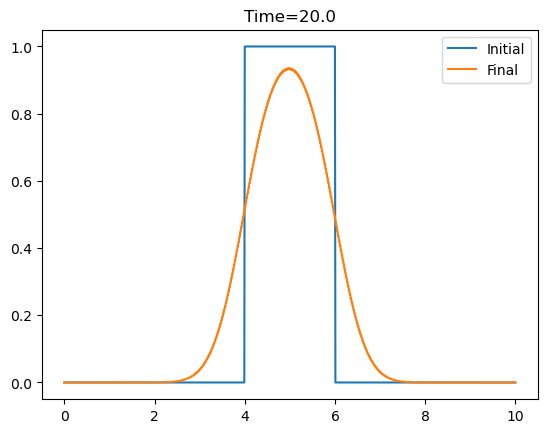

C:\Users\restu\AppData\Local\Temp\ipykernel_19284\28187744.py:116: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('./images/'+file)


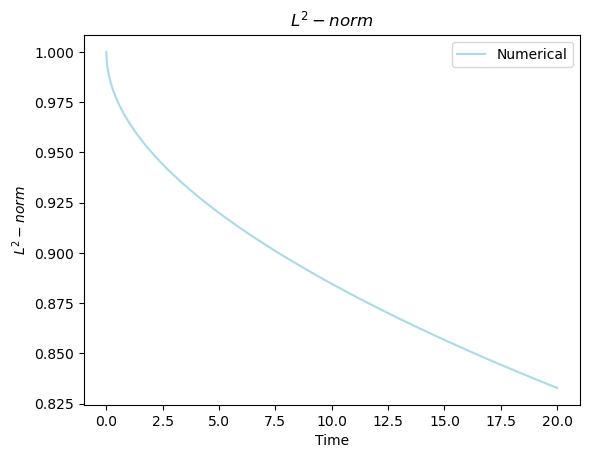

In [14]:
advection_equation(function='Step', nx=1001, method='Lax_Friedrichs')